$\newcommand{\ket}[1]{\left|#1\right>}$

$\newcommand{\bra}[1]{\left<#1\right|}$

$\newcommand{\braket}[2]{\left<#1 | #2\right>}$

$\newcommand{\expectation}[1]{\left<#1\right>}$

# The Max Cut Problem

#### References
Qiskit Max Cut tutorial: https://qiskit.org/textbook/ch-applications/qaoa.html <br>
Qiskit VQE tutorial: https://qiskit.org/textbook/ch-applications/vqe-molecules.html <br>
Wikipedia: https://en.wikipedia.org/wiki/Maximum_cut


## Problem Definition

Let's consider a non-directed graph with $n$ vertices and $m$ edges.

The Max Cut problems aim to find the two complementary subsets of vertices such that the number of edges connecting vertices of different subsets is maximal.

This can be more easily visualized through an example, so that we can consider a graph G(V,E) with:
- n = 5 vertices: $V = \{V_1, V_2, V_3, V_4, V_5\}$;
- m = 6 edges: $E = \{(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)\}$;
- as we can see below, the graph is organized so that it recalls the shape of a butterfly.

We can use a small piece of code to formalize the graph and show it.

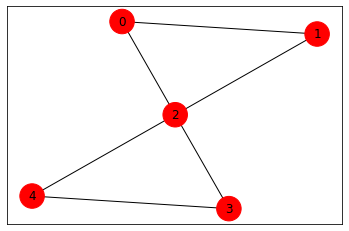

In [95]:
# Tools to handle general graphs
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt 

# Graph parameters 
n = 5
V = np.arange(0,n,1)
E = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

# Generating the butterfly graph with 5 nodes
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Plot the graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, 
                 node_color = colors, 
                 node_size  = 600, 
                 alpha      = 1, 
                 ax         = default_axes, 
                 pos        = pos)

This is clearly a combinatorial optimization problem, since in principle we should try all the possible compositions of subsets and count the number of edges connecting vertices of different subsets.

We can formalize our problem as a quadratic unconstrained binary optimization problem (QUBO), if we define the two subsets as $V1$ and $V2$ so that:
- the vertices in $V1$ get are assigned a value 0: $x_i = 0 ~\forall~ V_i \in V1$;
- the vertices in $V2$ get are assigned a value 0: $x_i = 1 ~\forall~ V_i \in V2$.

Additionally, we introduce a weight matrix $w_{ij}$ with:
- $w_{ii} = 0$ (a vertex is never connected to itself);
- $w_{ij} = 1$ for existing edges;
- $w_{ij} = 0$ for if vertex $V_i$ and vertex $V_j$ are not connected by any edge;
- $w_{ij} = w_{ji}$.

Thanks to this, we can defined a cost function that we would like to maximize:

$$ C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1 - x_j)$$

where we can see that if two vertices belong to the same subset, the contribution to the cost function is 0 (at least one of the two terms $x_i$ or $(1 - x_j)$ is 0), while for vertices belonging to complementary subsets, the contribution is 1. The fact that $x_i$ must be 1 and $x_j$ must be 0, avoids counting twice the same edge.

A more general approach may introduce different weights for different edges, so that $w_{ij} \neq 1$, but always keeping $w_{ij} > 0$.

## Problem Resolution: Brute Force Approach

Independently on the values of the weights, the problem is $NP$, since testing all the possible combinations of subsets $V1$ and $V2$ requires $2^n - 2$ (all the element in $V1$ or all the element in $V2$ are not valid solutions) evaluations of the cost function.
This approach is called *brute force* and is strongly inefficient, so that it cannot be used even for not-so-large values of n.

We can try and implement such approach in this case and use the results as a cross-check to test alternative ways of solving the problem.

In particular, in order to have just one possible solution, we are going to give all the edges weight 1, but the edges connecting to vertes $V_2$, which will have weight 2.

case = [0, 0, 0, 0, 0] score = 0
case = [1, 0, 0, 0, 0] score = 3
case = [0, 1, 0, 0, 0] score = 3
case = [1, 1, 0, 0, 0] score = 4
case = [0, 0, 1, 0, 0] score = 8
case = [1, 0, 1, 0, 0] score = 7
case = [0, 1, 1, 0, 0] score = 7
case = [1, 1, 1, 0, 0] score = 4
case = [0, 0, 0, 1, 0] score = 3
case = [1, 0, 0, 1, 0] score = 6
case = [0, 1, 0, 1, 0] score = 6
case = [1, 1, 0, 1, 0] score = 7
case = [0, 0, 1, 1, 0] score = 7
case = [1, 0, 1, 1, 0] score = 6
case = [0, 1, 1, 1, 0] score = 6
case = [1, 1, 1, 1, 0] score = 3
case = [0, 0, 0, 0, 1] score = 3
case = [1, 0, 0, 0, 1] score = 6
case = [0, 1, 0, 0, 1] score = 6
case = [1, 1, 0, 0, 1] score = 7
case = [0, 0, 1, 0, 1] score = 7
case = [1, 0, 1, 0, 1] score = 6
case = [0, 1, 1, 0, 1] score = 6
case = [1, 1, 1, 0, 1] score = 3
case = [0, 0, 0, 1, 1] score = 4
case = [1, 0, 0, 1, 1] score = 7
case = [0, 1, 0, 1, 1] score = 7
case = [1, 1, 0, 1, 1] score = 8
case = [0, 0, 1, 1, 1] score = 4
case = [1, 0, 1, 1, 1] score = 3
case = [0,

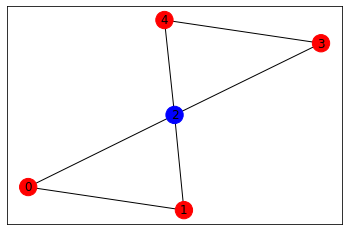

In [96]:
import numpy as np
import networkx as nx

# number of characters
n = 5

# W matrix definition
W = np.array([[0, 1, 2, 0, 0],
              [1, 0, 2, 0, 0],
              [2, 2, 0, 2, 2],
              [0, 0, 2, 0, 1],
              [0, 0, 2, 1, 0]])

best_cost_brute = 0

# computing all possible combinations
for b in range(2**n):
    # x stores all the 2^n possible combinations of 0 and 1
    # for a vector of length n 
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]

    # initialize cost function value
    cost = 0
    # scan all possible costs and keep the highest one
    # (now we want to maximize our score!)
    for i in range(n):
        for j in range(n):
            cost = cost + W[i,j]*x[i]*(1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' score = ' + str(cost))

# Showing results    
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute)) 

As expected by the way we constructed the problem, the highest score is obtained when $V_2$ is alone in one of the two subsets of $V$.

## Problem Resolution: Ising Hamiltonian

If we want to try and solve the problem more efficiently using a quantum computer, the first step consists in transforming it from a QUBO problem to a Ising Hamiltonian. To get the solution of the problem, we will have to find the fundamental state of the Hamiltonian.

The result is the same (even if we are now going to look for a minimum, instead of a maximum), but this new formalism better adapts to the dual state that a qbit can assume:

$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$

where $\alpha$ and $\beta$ are complex coefficients that satisfy the relation:

$ |\alpha|^2 + |\beta|^2 = 1 $


To do so, we have to perform some transformations to the original formulation of the problem:
- $x_i \rightarrow 
    \dfrac{1}{2}
    (\mathbb{1} + \sigma_z)_i = 
    \dfrac{1}{2}
    \left[
    \mathbb{1} + 
    \begin{bmatrix}
    1 &  0 \\
    0 & -1
    \end{bmatrix}
    \right]_i = 
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}_i
    $<br>
    where the operator acts only on the corresponding states and has the following properties:
    - $ \begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix} = 
        1 \cdot
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix}$ <br>
        $\begin{bmatrix}
        1 \\
        0
        \end{bmatrix}$ is eigenvector of 
        $\begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}$
        with eigenvalue 1. <br>
        This means that $x_i = 1 \rightarrow         
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix} = \ket{1}$
    - $ \begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix} = 
        0 \cdot
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix}$ <br>
        $\begin{bmatrix}
        0 \\
        1
        \end{bmatrix}$ is eigenvector of 
        $\begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}$
        with eigenvalue 0. <br>
        This means that $x_i = 0 \rightarrow         
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix} = \ket{0}$

- consequently, we will replace:
$(1 - x_i) \rightarrow 
    \left[
    \mathbb{1} -     
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}
    \right]_i = 
    \begin{bmatrix}
    0 & 0 \\
    0 & 1
    \end{bmatrix}_i$

- for every entry of the original $n x n$ QUBO matrix, take the entry $(i,j)$ and multiply it by the tensor product from $1$ to $n$ of $2 x 2$ identities, with the excpetion of the $i$-th and $j$-th terms of the product, which are the $2 x 2$ matrices corresponding to $x_i$ and $(1 - x_j)$. The sum of all these products is a diagonal $2^n x 2^n$ matrix, whose entries are the expectation values obtained with the *brute force* algorithm and corresponds to the Ising Hamiltonian associated to the problem. 

Since the process of converting a QUBO problem is not straightforward, let's make it clearer by doing it for the current problem, using a simple function.

In [97]:
# Define the 2x2 matrices we need

# (1 + pauli_z)/2
sigma_z = np.array([[1, 0], [0, 0]])

# (1 - sigma_z)
minus_z = np.array([[0, 0], [0, 1]])

# Identity
id_matrix = np.array([[1, 0], [0, 1]])

In [98]:
# The actual function
def qubo_to_ising(input_Q):
    n = len(input_Q)
    print("input:")
    print(input_Q)
    print("")
    
    # initialize H
    H = 0

    # compute the contribution of the i,j term to the Hamiltonian
    # i = left-side term = x_i (corresponds to sigma_z)
    for i in range(n):
        # j = right-side term = (1 - x_j) (corresponds to minus_z)
        for j in range(n):            
            # first term
            matrix_ij = 0
            if i == 0:
                matrix_ij = sigma_z
            elif j == 0:
                matrix_ij = minus_z
            else:
                matrix_ij = id_matrix
            
            # tensor product n times
            for k in range(1,n):
                if i == k:
                    new_term = sigma_z
                elif j == k:
                    new_term = minus_z
                else:
                    new_term = id_matrix                
                matrix_ij = np.kron(matrix_ij, new_term)

            # multiply by the i,j term of input_Q 
            matrix_ij = matrix_ij * input_Q[i,j]
            
            # sum
            H = H + matrix_ij
    
    return(-H) 

In [99]:
# Translate our QUBO matrix to a Ising Hamiltonian
H = qubo_to_ising(W)

print('Ising Hamiltonian dimensions:' + str(H.shape))
print("")

# Check eigenvalues
print("Ising eigenvalues:")
eigenvalues = []
for i in range(len(H)):
    eigenvalues.append(H[i,i])
print(eigenvalues)    

input:
[[0 1 2 0 0]
 [1 0 2 0 0]
 [2 2 0 2 2]
 [0 0 2 0 1]
 [0 0 2 1 0]]

Ising Hamiltonian dimensions:(32, 32)

Ising eigenvalues:
[0, -3, -3, -4, -8, -7, -7, -4, -3, -6, -6, -7, -7, -6, -6, -3, -3, -6, -6, -7, -7, -6, -6, -3, -4, -7, -7, -8, -4, -3, -3, 0]


## Problem Resolution: Variational Quantum Eigensolver (VQE)

We have seen that the Ising formulation is equivalent to the standard QUBO formulation of optimization problem and we state that it is more suited the resolution on a quantum computer. On the other hand, we still need $2^n$ evaluations of the Hamiltonian if we want to find the optimal solution.

One possible way to exploit quantum computers to try and solve optimization problems more efficiently is through the so-called Variational Quantum Eigensolver (VQE) algorithm.

It exploits the rapidity of a quantum computer in evaluating the cost function for a given quantum state $\ket{\psi}$ and associates it with a classical optimizer that helps in finding the optimal one.

### VQE: basic concepts

To uderstand the idea behind VQE, we start by introducing the concepts of eigenvalue and eigenvector (or eigenstate), defined through the following relation:

$$ H \ket{\psi_i} = \lambda_i \ket{\psi_i}$$

where $H$ is the matrix describing the Hamiltonian, $\lambda_i$ is a eigenvalue and $\ket{\psi_i}$ is a eigenvector.
In our case, the Hamiltonian $H$ is described by a diagonal matrix and the eigenvalues correspond to its diagonal entries and the eigenstates are the vectors:

$$ \ket{\psi_i} = \{ \ket{00000}, \ket{00001}, \ket{00010}, \ket{00011}, ...\} $$

This follows from the fact that in quantum mechanics, the outcome of a measurement can give only a discrete set of results. In particular, this set of results corresponds to the eigenvalues of the Hamiltonian $H$ describing the quantum system that we are measuring and each eigenvalue is associated to one eigenvector, or eigenstate of the system. 

The eigenvectors represent a basis of the space of the possible states of the quantum system, so that a general state $\psi$ can be written as:

$$ \ket{\psi} = \sum_i^N \alpha_i \ket{\psi_i}$$

where in our case $N = 2^n$ is the number of eigenvalues and $\alpha_i$ is the projection of $\ket{\psi}$ on the eigenvector $\ket{\psi_i}$:

$$ \alpha_i = \braket{\psi_i}{\psi} $$

And the Hamiltonian can be expressed as:

$$ H = \sum_i^{N} \lambda_i \ket{\psi_i} \bra{\psi_i}$$

The solution of our problem is the eigenvector associated to the smallest eigenvalue (let's call them $\lambda_{min}$ and $\ket{\psi_{min}}$). 
In general, the outcome of a measurement (or expectation value) is always larger than the one obtained when the system is in the *fundamental state* $\ket{\psi_{min}}$:

$$ \lambda_{min} = \expectation{\psi_{min}|H|\psi_{min}} \leq
\expectation{\psi|H|\psi} = 
\bra{\psi} \left( \sum_i^{N} \lambda_i \ket{\psi_i} \bra{\psi_i} \right) \ket{\psi} = 
\sum_i^{N} \lambda_i \braket{\psi}{\psi_i} \braket{\psi_i}{\psi} = 
\sum_i^{N} \lambda_i |\braket{\psi_i}{\psi}|^2 $$

In other words, a large projection of the current state on the fundamental state, which is our solution, will produce a small expected value.

The idea of VQE is to start with a reasonable ansatz for $\ket{\psi}$ (which for example is a superposition of all the possible eigenstates) and iteratively changing its eigenstate composition, typically through a series of rotations (we call this *optimization*), until we find the optimal solution or until we are satisfied with how close we are to it.

### On the expected value

It is important at this point make that a single measurement gives only one of the possible results allowed.

For example, in our case, if we prepare our state $\ket{\psi}$ such that it corresponds to the case (0, 0, 1, 0, 0), we will get, for every measurement, the result $\lambda_{min} = -8$.
In general, keeping in mind the probabilistic nature of quantum mechanics, a state:

$$ \ket{\psi} = \sum_i^N \alpha_i \ket{\psi_i} $$

will return as result the eigenvalue $\lambda_i$ with probability $| \alpha_i|^2$.

This means that, for every state $\ket{\psi}$ that we consider, several measurements have to be performed in order to have an idea of how *large* or *small* the expected value is.

Moreover, in our simple case we know all the eigenvalues of the Hamiltonian, while in general they may be so many that it is not convenient to explicitly get them, since it would correspond to solve the problem by *brute force*, making the optimization algorithm role even more delicate.

### VQE: Ansatz

First of all, when preparing the ansatz for our solution, we have to consider that we will need one qbit for every vertex of our graph. In our case, we will need $n = 5$ qbits.

Then, we want our ansatz:
- to be able to cover the largest possible number of states $\rightarrow$ more parameters;
- to have a small number of gates: many gates may introduce errors and may make more difficult to converge towards a sensible solution $\rightarrow$ less parameters.

The choice will have to be a trade-off between these two opposite requirements.

Among many possible possibilities, the so-called RY ansatz is quite popular and consists of:
1. put every qbit in the $\ket{+} = \dfrac{\ket{0} + \ket{1}}{\sqrt{2}}$ state through a rotation of $\frac{\pi}{2}$ around the y-axis of its Bloch sphere;
- connect (or introduce entanglement among) different qbits, for example between pair of qbits;
- introduce for each qbit a rotation around the y-axis of its Bloch sphere (RY-gate). The rotation angles are the parameters to be adjusted during the optimization process;
- repeat step 2. and 3. for a chosen number of times, keeping in mind that more RY-gates means more parameters for the optimizer.

The entanglement between two qbits can be obtained by applying a controlled gate, a gate that applies a transformation on a target qbit only if the control qbit is in the $\ket{1}$ state.
In our case, we will apply controlled z-gates.

The RY ansatz is particularly popular since it allows to span a large number of states without introducing any complex phase, thanks to the fact that all the rotations are performed around the y- axis of the Bloch sphere.

Let's try and prepare the ansatz for our problem using qiskit.

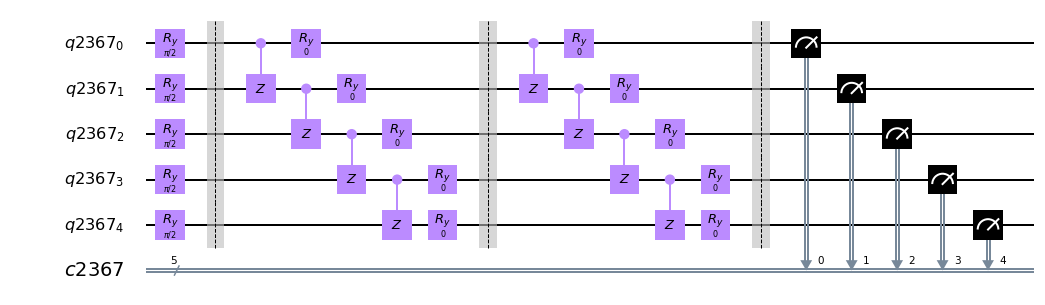

In [100]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

PI = np.pi

# Number of qbits
n = 5

# Define the Quantum and Classical Registers
q = QuantumRegister(n)
c = ClassicalRegister(n)

# Build the circuit for the ansatz
circuit = QuantumCircuit(q, c)

# Put all the qbits in the |+> state
theta_hadamard = [PI/2,PI/2,PI/2,PI/2,PI/2]
for i in range(n):
    circuit.ry(theta_hadamard[i],q[i])
circuit.barrier()

# Apply controlled-z gates (first layer)
for i in range(n-1):
    circuit.cz(q[i], q[i+1])

# Introduce RY-gates (first layer)
theta_0 = [0.,0.,0.,0.,0.]
for j in range(n):
    circuit.ry(theta_0[j],q[j])
circuit.barrier()

# Apply controlled-z gates (second layer)
for i in range(n-1):
    circuit.cz(q[i], q[i+1])
    
# Introduce RY-gates (second layer)
theta_1 = [0.,0.,0.,0.,0.]
for j in range(n):
    circuit.ry(theta_1[j],q[j])
circuit.barrier()

# Close the circuit with qbits measurements
circuit.measure(q, c)

# Draw the circuit    
circuit.draw(output='mpl')

In [101]:
# Execute the circuit on a simulator
job = execute(circuit, 
              backend = Aer.get_backend('qasm_simulator'), 
              shots   = 1024)

result = job.result()

# Print the result
print(result.get_counts(circuit))

{'01000': 24, '00001': 25, '01001': 31, '00111': 38, '01011': 29, '10000': 37, '00000': 24, '10011': 39, '00100': 28, '11100': 34, '10101': 33, '10110': 28, '01101': 31, '11110': 47, '11011': 24, '01110': 35, '11010': 40, '10010': 32, '10100': 41, '01100': 25, '01010': 32, '00011': 28, '11111': 32, '00010': 43, '10001': 29, '10111': 40, '00101': 30, '11001': 30, '11000': 33, '01111': 28, '11101': 26, '00110': 28}


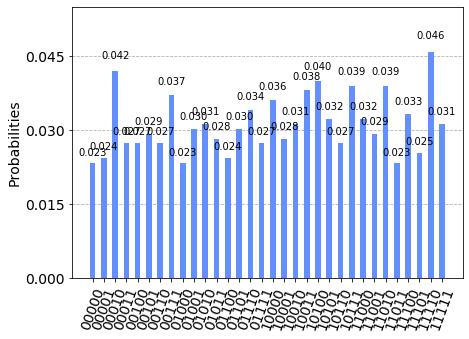

In [102]:
# Plot the result
from qiskit.visualization import plot_histogram

plot_histogram(result.get_counts(circuit))

### Cost function evaluation

So we have been able to prepare a circuit for the ansatz of our optimal solution and we have evaluated it 1024 times, observing that all the possible outcomes are represented almost uniformly.

However, if we want to optimize the 15 rotation angles we introduced to obtain the optimal solution, this is not enough: to decide if our current solution is good enough or we need more iterations to tune its paramters, we need to evaluate its cost function.

Since we are evaluating many times (1024 in our case) the cost function, we will have many values to deal with and we can choose among different figures of merit to extract a quantitative evaluation of the goodness of the current solution.
The more intuitive and naive is the mean value, which we implement here.

Using this figure of merit, our best solution will be the one giving the smallest cost function value.

In [103]:
# Compute the value of the cost function

# results: the outcome of the circuit measurement
# weights: the original QUBO matrix
def cost_function_C(results, weights):
    
    # the eigenstates obtained in the evaluation of the circuit
    eigenstates = list(results.get_counts().keys())
    
    # how many times each eigenstate has been sampled
    abundancies = list(results.get_counts().values())
    
    # number of shots 
    shots = sum(result.get_counts().values())
    
    # initialize the cost function
    cost = 0
    
    for k in range(len(eigenstates)):
        # ndarray of the digits extracted from the eigenstate string 
        x = np.array([int(num) for num in eigenstates[k]])
        # Cost function due to the k-th eigenstate
        cost = cost + x.dot(W.dot(1-x)) * abundancies[k]
    
    return -cost / shots

In [104]:
# The cost function given by the ansatz 
ansatz_cost = cost_function_C(result, W)
print(ansatz_cost)

-4.978515625


### Optimizer

Now that we have an ansatz and we have defined our cost function, we want to use a classical optimizer to find the rotation angles that we need to obtain the solution of our problem.

To do so, we have to define the ansatz as a parametric circuit, where the rotation angles of the RY gates are not given as numbers, but appear only as parameters that can be passed to the function that generates the circuit. 

This is not the only technical detail we have to consider, since in order to use the classical optimizer as it is defined in scipy libraries (https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html), it is a good idea to include the creation and execution of the circuit inside the function that evaluates its cost.

Once also this change to the cost function definition is implemented, we can finally call the optimizer to get the angles that rotates our ansatz into the solution of the problem.

For this problem, we are using the Constrained optimization by linear approximation (COBYLA), a derivative-free, numerical optimization method used for constrained problem (https://en.wikipedia.org/wiki/COBYLA).

In [105]:
# Write the circuit as a parametric function
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

def VQE_circuit(theta, n, depth): 
    """Creates a variational-form RY ansatz.
    
    theta: (depth+1 x n) matrix of rotation angles,
    n: number of qbits,
    depth: number of layers.
    """
        
    if len(theta.ravel()) != ((depth+1) * n):        
        raise ValueError("Theta cannot be reshaped as a (depth+1 x n) matrix")

    theta.shape = (depth + 1, n)

    # Define the Quantum and Classical Registers
    q = QuantumRegister(n)
    c = ClassicalRegister(n)

    # Build the circuit for the ansatz
    circuit = QuantumCircuit(q, c)

    # Put all the qbits in the |+> state
    for i in range(n):
        circuit.ry(theta[0,i],q[i])
    circuit.barrier()
    
    # Now introduce the z-gates and RY-gates 'depth' times
    for j in range(depth):
        # Apply controlled-z gates
        for i in range(n-1):
            circuit.cz(q[i], q[i+1])

        # Introduce RY-gates
        for i in range(n):
            circuit.ry(theta[j+1,i],q[i])
        circuit.barrier()
    
    # Close the circuit with qbits measurements
    circuit.measure(q, c)
    
    return circuit    

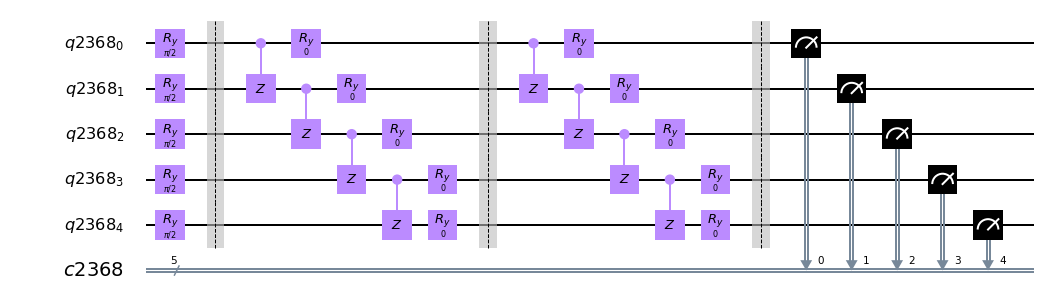

In [106]:
# Draw an example circuit
theta = np.array([[PI/2,PI/2,PI/2,PI/2,PI/2],
                  [0.,0.,0.,0.,0.,],
                  [0.,0.,0.,0.,0.,]])

n_qbits = 5 
depth   = 2

VQE_circuit(theta, 5, 2).draw(output = 'mpl')

In [107]:
# Include the creation and execution of the circuit inside the function
# that computes the value of its cost

# In case you want to use a real quantum device as backend
from qiskit import IBMQ

def cost_function_cobyla(params, 
                         weights,   # = W, 
                         n_qbits,   # = 5, 
                         depth,     # = 2,
                         shots,     # = 1024
                         backend_name = 'qasm_simulator',
                         verbosity    = False):
    """Creates a circuit, executes it and computes the cost function.
    
    params: ndarray with the values of the parameters to be optimized,
    weights: the original QUBO matrix of the problem,
    n_qbits: number of qbits of the circuit,
    depth: number of layers of the ciruit,
    shots: number of evaluations of the circuit state,
    verbosity: activate/desactivate some control printouts.
    
    The function calls 'VQE_circuit' to create the circuit, then
    evaluates it and compute the cost function.
    """
    
    if (verbosity == True):
        print("Arguments:")
        print("params  = \n", params)
        print("weights = \n", weights)
        print("qbits   = ", n_qbits)
        print("depth   = ", depth)
        print("shots   = ", shots)
        print("backend = ", backend_name)
    
    circuit = VQE_circuit(params, n_qbits, depth)
    circuit.draw(output = "mpl")
    
    if backend_name == 'qasm_simulator':
        backend = Aer.get_backend('qasm_simulator')
    else:
        provider = IBMQ.load_account()
        backend = provider.get_backend(backend_name)
    
    # Execute the circuit on a simulator
    job = execute(circuit, 
                  backend = backend, 
                  shots   = shots)
    results = job.result()
    
    # the eigenstates obtained in the evaluation of the circuit
    eigenstates = list(results.get_counts().keys())
    
    # how many times each eigenstate has been sampled
    abundancies = list(results.get_counts().values())
    
    # number of shots 
    shots = sum(result.get_counts().values())
    
    # initialize the cost function
    cost = 0
    
    for k in range(len(eigenstates)):
        # ndarray of the digits extracted from the eigenstate string 
        x = np.array([int(num) for num in eigenstates[k]])
        # Cost function due to the k-th eigenstate
        cost = cost + x.dot(W.dot(1-x)) * abundancies[k]
    
    if (verbosity == True):
        print("cost = ", -cost/shots)

    return -cost / shots

In [108]:
# Scipy implementation of the COBYLA optimizer

from scipy.optimize import minimize

# Initial rotation angles of the RY ansatz
theta = np.array([[PI/2,PI/2,PI/2,PI/2,PI/2],
                  [0.,0.,0.,0.,0.,],
                  [0.,0.,0.,0.,0.,]])

# Classical optimizer tuning
res = minimize(fun     = cost_function_cobyla, 
               x0      = theta.ravel(),     # the 'params' argument of 'cost_function_cobyla'
               method  = 'COBYLA',          # we want to use the COBYLA optimization algorithm
               options = {'maxiter': 500},  # maximum number of iterations
               tol     = 0.0001,            # tolerance or final accuracy in the optimization 
               args    = (W, 5, 2, 1024,
                         "qasm_simulator")) # the arguments of 'cost_function_cobyla', except 'params'

In [109]:
# Obtain the output distribution using the final parameters
optimal_circuit = VQE_circuit(res.x, 5, 2)

backend = Aer.get_backend('qasm_simulator')
NUM_SHOTS = 1024

counts = execute(optimal_circuit, 
                 backend, 
                 shots = NUM_SHOTS).result().get_counts(optimal_circuit)

print("Optimal rotation angles:\n", res.x)
print()

# To trust the optimizer is fine, but it is better to check ;) 
print("Cost function with the optimal angles (according to scipy):", res.fun)
print("Cost function with the optimal angles (actual evaluation):",  cost_function_cobyla(res.x, W, 5, 2, 1024))

Optimal rotation angles:
 [[ 3.12264141  2.45319871  0.33343345  3.13790621 -0.14710204]
 [-0.2849644  -1.1617353  -0.67361779 -0.11093806  2.35982653]
 [-0.58422245 -0.55676423  0.46959809 -0.09428839 -0.52702333]]

Cost function with the optimal angles (according to scipy): -7.96484375
Cost function with the optimal angles (actual evaluation): -7.9375


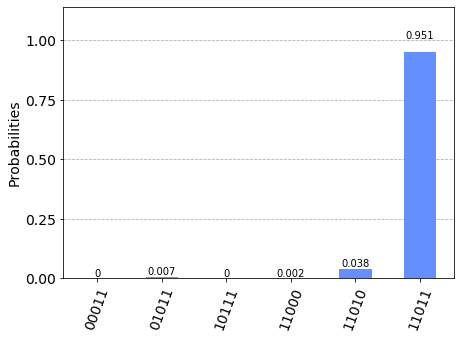

In [110]:
# Plot the result
from qiskit.visualization import plot_histogram

plot_histogram(counts)

# Random stuff and work in progress

In [ ]:
import math
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.ising import max_cut
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.ising.common import sample_most_likely
from qiskit.aqua.operators import MatrixOperator

##### Simulación caso ideal

In [ ]:
from qiskit.optimization.ising import max_cut

H, const = max_cut.get_operator(W)

In [ ]:
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.optimization.ising.common import sample_most_likely

#Comprobamos el Hamiltoniano construido mediante un algoritmo clásico
ee = ExactEigensolver(H)
result = ee.run()

x = sample_most_likely(result['eigvecs'][0])
print('Energy:', result['energy'])
print('Solution:', max_cut.get_graph_solution(x))
print('Solution objective:', max_cut.max_cut_value(x, W))
#Nos quedamos con la solución correcta en sol 
sol=[]
for i in range(2**n):
    if result['eigvecs'][0][i]!=0:
        sol.append(i)

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors)

In [ ]:
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.algorithms import VQE

seed = 10598

# Optimizer
cobyla = COBYLA() 

# Ansatz
ry = RY(n, 
        depth=2, 
        entanglement='linear') 

# VQE algorithm
vqe = VQE(H, ry, cobyla)

In [ ]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance

backend = BasicAer.get_backend('statevector_simulator')

quantum_instance = QuantumInstance(backend=backend, 
                                   seed_simulator=seed, 
                                   seed_transpiler=seed)

resultvqe = vqe.run(quantum_instance)

In [ ]:
x = sample_most_likely(resultvqe['eigvecs'][0])

print('Energy:',resultvqe['energy'])
print('Time:', resultvqe['eval_time'])
print('Function objetive:', max_cut.max_cut_value(x, W))

print('Wave function solution:', [round(x,5) for x in resultvqe['eigvecs'][0]],'\n')

print('Bits solution (most likely):', max_cut.get_graph_solution(x) )

print('Overlap:',np.abs(resultvqe['eigvecs'][0,sol])**2)

##### Ejecución en dispositivo cuántico simulado

In [ ]:
#Cuenta en IBMQ Experience

backend = BasicAer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend              = backend, 
                                   seed_simulator       = seed, 
                                   seed_transpiler      = seed,
                                   skip_qobj_validation = False,
                                   shots                = 1024)

resultvqe = vqe.run(quantum_instance)

In [ ]:
resultvqe["min_vector"]